# DS project: predicting song popularity by genre - Kathy Li, Sa Qu, Rulan Xiao

## Data preparation

In [75]:
import numpy as np
import scipy
import os
import sklearn as skl
import pandas as pd
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import pylab as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [76]:
# Load metadata and features - change to local directory for tracks file
tracks = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/tracks.csv', header=None)
echonest = pd.read_csv('echonest.csv', header=None)

/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171

In [77]:
# Change column names from "track.1", ... to named columns
header = tracks.iloc[1]
header[0] = 'track_ID'
tracks.drop(tracks.index[[0,1,2]], inplace=True)
tracks.rename(columns=header, inplace=True)

header = echonest.iloc[2]
header[0]='track_ID'
echonest.drop(echonest.index[[0,1,2,3]],inplace=True)
echonest.rename(columns = header,inplace=True)

# Only select songs for which we have echonest data
tracks_with_echonest_data = tracks[tracks['track_ID'].isin(echonest['track_ID'])]
echonest_data = echonest[echonest['track_ID'].isin(tracks_with_echonest_data['track_ID'])]

merged_echonest_data = pd.merge(tracks_with_echonest_data, echonest_data, on = 'track_ID')

# Change duplicate "listens" column to track listens and album listens
duplicate_listens = {'listens': ['album_listens', 'track_listens']}

merged_echonest_data = merged_echonest_data.rename(columns=lambda c: duplicate_listens[c].pop(0) if c in duplicate_listens.keys() else c)

In [78]:
# Extract year released from release date variable
album_release_year = []

for x in merged_echonest_data['date_released']:
    if type(x)==str:
        album_release_year.append(x[0:4])
    else: 
        album_release_year.append(np.nan)

#add album release year to dataframe
merged_echonest_data['album_release_year'] = album_release_year

# Check number of songs released per year and pick year with maximum
import collections
counter=collections.Counter(album_release_year)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

Counter({nan: 3140, '2010': 1461, '2009': 1426, '2011': 1101, '2008': 1088, '2007': 464, '2012': 380, '2006': 346, '2013': 298, '2014': 245, '2004': 167, '2005': 150, '2015': 145, '2003': 94, '2002': 84, '2001': 69, '1999': 68, '2000': 34, '1997': 25, '1995': 20, '1982': 19, '1998': 17, '1996': 10, '1986': 10, '1981': 6, '1973': 5, '1985': 5, '1992': 3, '1913': 2, '1976': 2, '1912': 1, '1916': 1, '1911': 1, '1909': 1, '1905': 1, '1907': 1, '1988': 1, '1902': 1})
dict_values([1426, 1088, 464, 150, 20, 346, 3140, 94, 19, 6, 69, 84, 167, 34, 68, 10, 1, 1, 1, 2, 1, 1, 1, 25, 3, 1, 17, 1461, 2, 10, 1101, 5, 245, 380, 298, 5, 1, 145])
dict_keys(['2009', '2008', '2007', '2005', '1995', '2006', nan, '2003', '1982', '1981', '2001', '2002', '2004', '2000', '1999', '1996', '1912', '1916', '1911', '1913', '1909', '1905', '1907', '1997', '1992', '1988', '1998', '2010', '1976', '1986', '2011', '1973', '2014', '2012', '2013', '1985', '1902', '2015'])
[(nan, 3140), ('2010', 1461), ('2009', 1426)]


In [79]:
# For chosen year, check the number of songs released per genre; pick top three genres to use
tracks_2010 = merged_echonest_data[merged_echonest_data['album_release_year'] == '2010']

# Top genres for 2010
counter=collections.Counter(tracks_2010['genre_top'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({nan: 524, 'Rock': 372, 'Electronic': 271, 'Hip-Hop': 133, 'Folk': 67, 'Pop': 58, 'Jazz': 23, 'International': 12, 'Instrumental': 1})
dict_values([23, 372, 58, 271, 524, 133, 67, 12, 1])
dict_keys(['Jazz', 'Rock', 'Pop', 'Electronic', nan, 'Hip-Hop', 'Folk', 'International', 'Instrumental'])
[(nan, 524), ('Rock', 372), ('Electronic', 271), ('Hip-Hop', 133), ('Folk', 67), ('Pop', 58), ('Jazz', 23), ('International', 12), ('Instrumental', 1)]


In [7]:
# Add sentiment analysis by title into dataset - compound score of positive / negative sentiment for song title
# require to install nltk first
# this part work nice, file will be generated to our project folder. 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Read in track data - change to local directory
tracks_senti = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/tracks.csv',header=None)

header = tracks_senti.iloc[1]
header[0]='track ID'
header[52]='track title'
tracks_senti.drop(tracks_senti.index[[0,1,2]],inplace=True)
tracks_senti.rename(columns = header,inplace=True)
tracks_senti.head()

df=tracks_senti[['track ID','track title']]
df.dropna(axis=0, how='any')

ml = df["track title"].values
title=[]
for i in range(len(ml)):
    a=str(ml[i])
    title.append(a)
idd = df["track ID"].values

neg=[]
neu=[]
pos=[]
comp=[]

sid = SentimentIntensityAnalyzer()
for sentence in title:
    ss = sid.polarity_scores(sentence)
    score=[]
    for k in ss:
        a=ss[k]
        score.append(a)
    neg.append(score[0])
    neu.append(score[1])
    pos.append(score[2])
    comp.append(score[3])

#sentimentall = pd.DataFrame({'track_ID':idd,'track_title':title,'senti neg': neg,'senti neu': neu,'senti pos': pos,'senti comp': comp})

#sentimentall.to_csv('sentimental_analysis_title.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kathyli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
# Add sentiment to dataframe
sentiment= pd.read_csv('sentimental_analysis_title.csv')
sentiment=sentiment[['track_ID','senti comp', 'senti neg','senti pos']]
tracks_2010 = pd.merge(tracks_2010, sentiment, how='inner', on=['track_ID'])
tracks_2010.head()

track_ID comments         date_created        date_released engineer  \
0    26531        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
1    26532        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
2    26533        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
3    26534        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
4    27223        0  2010-03-14 11:40:47  2010-03-14 00:00:00      NaN   

  favorites    id                                        information  \
0         2  5763  <p>Improvising music is probably the best exam...   
1         2  5763  <p>Improvising music is probably the best exam...   
2         2  5763  <p>Improvising music is probably the best exam...   
3         2  5763  <p>Improvising music is probably the best exam...   
4         3  5883  <p>The Sakee Sed are Marco Grezzi and Gianluca...   

  album_listens producer    ...           218      219      220      221  \
0          7260      NaN    ...     0.0947888  0.06272  3.30952   3.2468   
1          7260      NaN    ...      0.556985  0.07887  10.1641  10.0852   
2          7260      NaN    ...      0.131889  0.06363  8.14385  8.08022   
3          7260      NaN    ...      0.118238  0.06381  7.81628  7.75247   
4          6282      NaN    ...     0.0100094  0.08762  0.70132   0.6137   

       222      223 album_release_year senti comp senti neg senti pos  
0   3.4673  19.3287               2010        0.0       0.0       0.0  
1    6.203  52.9757               2010        0.0       0.0       0.0  
2  8.10984  117.875               2010        0.0       0.0       0.0  
3  8.11471  123.621               2010        0.0       0.0       0.0  
4  1.18583  2.11265               2010        0.0       0.0       0.0  

[5 rows x 306 columns]

In [81]:
# Select the variables we want - named variables 
t10 = tracks_2010[['track_ID','latitude','longitude','bit_rate','duration','genre_top','track_listens','acousticness','danceability','energy','instrumentalness','liveness','speechiness','tempo','valence','artist_hotttnesss','artist_discovery','artist_familiarity', 'senti neg','senti pos']]
t10['popular'] = (t10['track_listens']>=1147.25).astype(int)
# For location (latitude, longitude), if na, change to 0
t10['latitude'].fillna(0, inplace=True)
t10['longitude'].fillna(0, inplace=True)

# For genre-specific models - split dataset into three based on top three genres
Hiphop_10=t10.loc[t10['genre_top'] == 'Hip-Hop']
Rock_10=t10.loc[t10['genre_top'] == 'Rock']
Elec_10=t10.loc[t10['genre_top'] == 'Electronic']

# For baseline model - add genre as a categorical variable 
t10['Rock'] = (t10['genre_top'] == 'Rock').astype(int)
t10['Hip-Hop'] = (t10['genre_top'] == 'Hip-Hop').astype(int)
t10['Electronic'] = (t10['genre_top'] == 'Electronic').astype(int)
t10.drop(['genre_top'], axis=1, inplace=True)

t10.astype(int).describe()

/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

track_ID     latitude    longitude       bit_rate     duration  \
count    1461.000000  1461.000000  1461.000000    1461.000000  1461.000000   
mean    39464.459274    27.995209   -20.156057  278633.140999   254.431896   
std     13616.675320    23.739467    49.874242   54456.429805   159.329293   
min     26531.000000   -40.000000  -122.000000  105073.000000    34.000000   
25%     32468.000000     0.000000   -73.000000  256000.000000   172.000000   
50%     36430.000000    39.000000     0.000000  320000.000000   230.000000   
75%     40931.000000    45.000000     5.000000  320000.000000   300.000000   
max    124911.000000    61.000000   174.000000  321934.000000  2367.000000   

       track_listens  acousticness  danceability  energy  instrumentalness  \
count    1461.000000        1461.0        1461.0  1461.0            1461.0   
mean     2082.902806           0.0           0.0     0.0               0.0   
std      7401.443595           0.0           0.0     0.0               0.0   
min        25.000000           0.0           0.0     0.0               0.0   
25%       275.000000           0.0           0.0     0.0               0.0   
50%       677.000000           0.0           0.0     0.0               0.0   
75%      1615.000000           0.0           0.0     0.0               0.0   
max    178139.000000           0.0           0.0     0.0               0.0   

          ...       valence  artist_hotttnesss  artist_discovery  \
count     ...        1461.0             1461.0            1461.0   
mean      ...           0.0                0.0               0.0   
std       ...           0.0                0.0               0.0   
min       ...           0.0                0.0               0.0   
25%       ...           0.0                0.0               0.0   
50%       ...           0.0                0.0               0.0   
75%       ...           0.0                0.0               0.0   
max       ...           0.0                0.0               0.0   

       artist_familiarity    senti neg    senti pos      popular         Rock  \
count              1461.0  1461.000000  1461.000000  1461.000000  1461.000000   
mean                  0.0     0.008898     0.010267     0.338809     0.254620   
std                   0.0     0.093941     0.100839     0.473467     0.435797   
min                   0.0     0.000000     0.000000     0.000000     0.000000   
25%                   0.0     0.000000     0.000000     0.000000     0.000000   
50%                   0.0     0.000000     0.000000     0.000000     0.000000   
75%                   0.0     0.000000     0.000000     1.000000     1.000000   
max                   0.0     1.000000     1.000000     1.000000     1.000000   

           Hip-Hop   Electronic  
count  1461.000000  1461.000000  
mean      0.091034     0.185489  
std       0.287755     0.388827  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000  

[8 rows x 23 columns]

In [82]:
# Take hip-hop, rock, and hip-hop together
t10['g']=t10['Rock']+ t10['Hip-Hop'] +t10['Electronic']
t10=t10.loc[t10['g'] == 1]
t10.drop(['g'],axis=1,inplace=True)

# only genres Hiphop, Rock and Electronic (separate dataframes)
Hiphop_10.drop(['genre_top'],axis=1,inplace=True)
Rock_10.drop(['genre_top'],axis=1,inplace=True)
Elec_10.drop(['genre_top'],axis=1,inplace=True)

/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


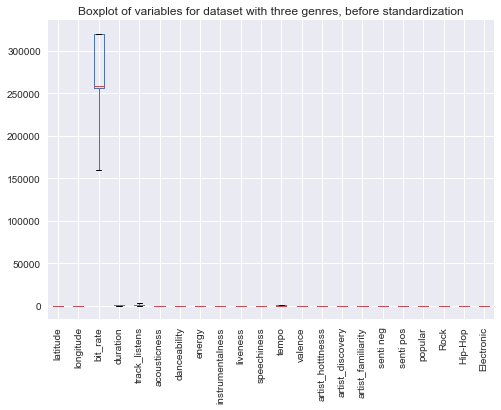

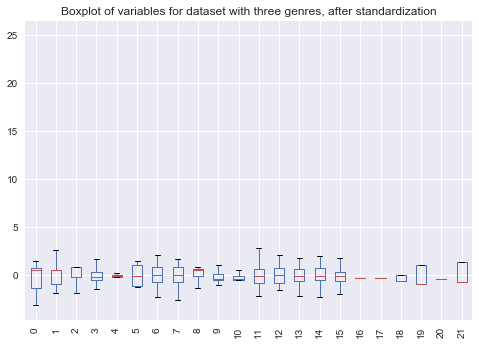

In [83]:
# Make boxplot of variables for t10 data (data with all three genres) - before standardization 
t10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for t10 data (data with all three genres) - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
t10_scaled = scaler.fit_transform(t10.drop(['track_ID'], axis=1))
t10_scaled = pd.DataFrame(t10_scaled)
t10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

t10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, after standardization')
plt.xticks(rotation=90)
plt.show()

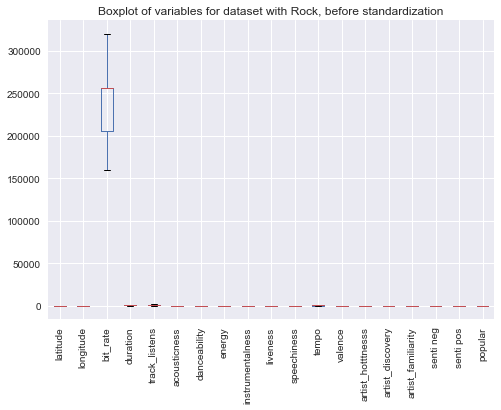

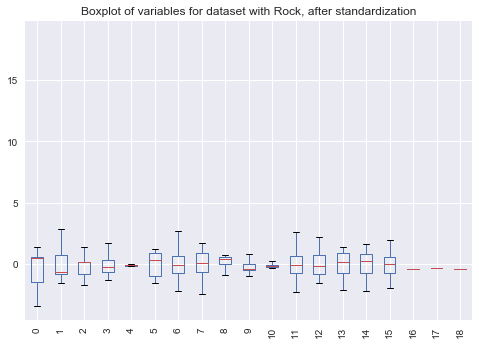

In [84]:
# Make boxplot of variables for rock data - before standardization 
Rock_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for rock data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Rock_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Rock_10_scaled = pd.DataFrame(Rock_10_scaled)
Rock_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Rock_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, after standardization')
plt.xticks(rotation=90)
plt.show()

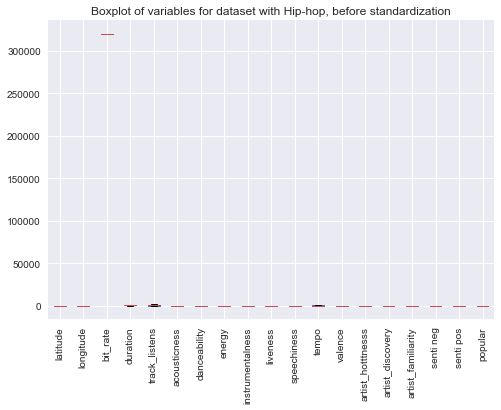

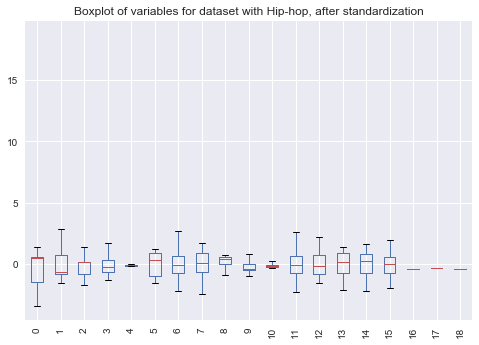

In [85]:
# Make boxplot of variables for hiphop data - before standardization 
Hiphop_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for hiphop data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Hiphop_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Hiphop_10_scaled = pd.DataFrame(Hiphop_10_scaled)
Hiphop_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Hiphop_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, after standardization')
plt.xticks(rotation=90)
plt.show()

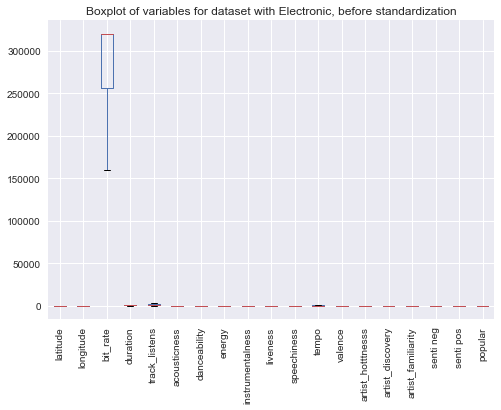

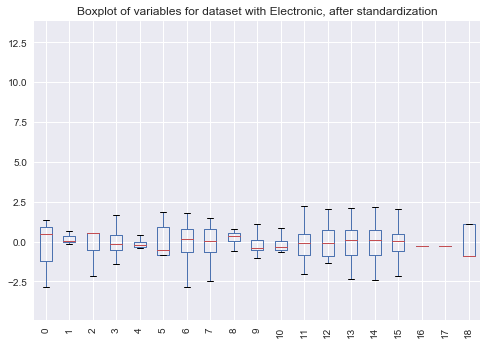

In [86]:
# Make boxplot of variables for electronic data - before standardization 
Elec_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for electronic data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Elec_10_scaled = scaler.fit_transform(Elec_10.drop(['track_ID'], axis=1))
Elec_10_scaled = pd.DataFrame(Elec_10_scaled)
Elec_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Elec_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, after standardization')
plt.xticks(rotation=90)
plt.show()

## Exploratory analysis

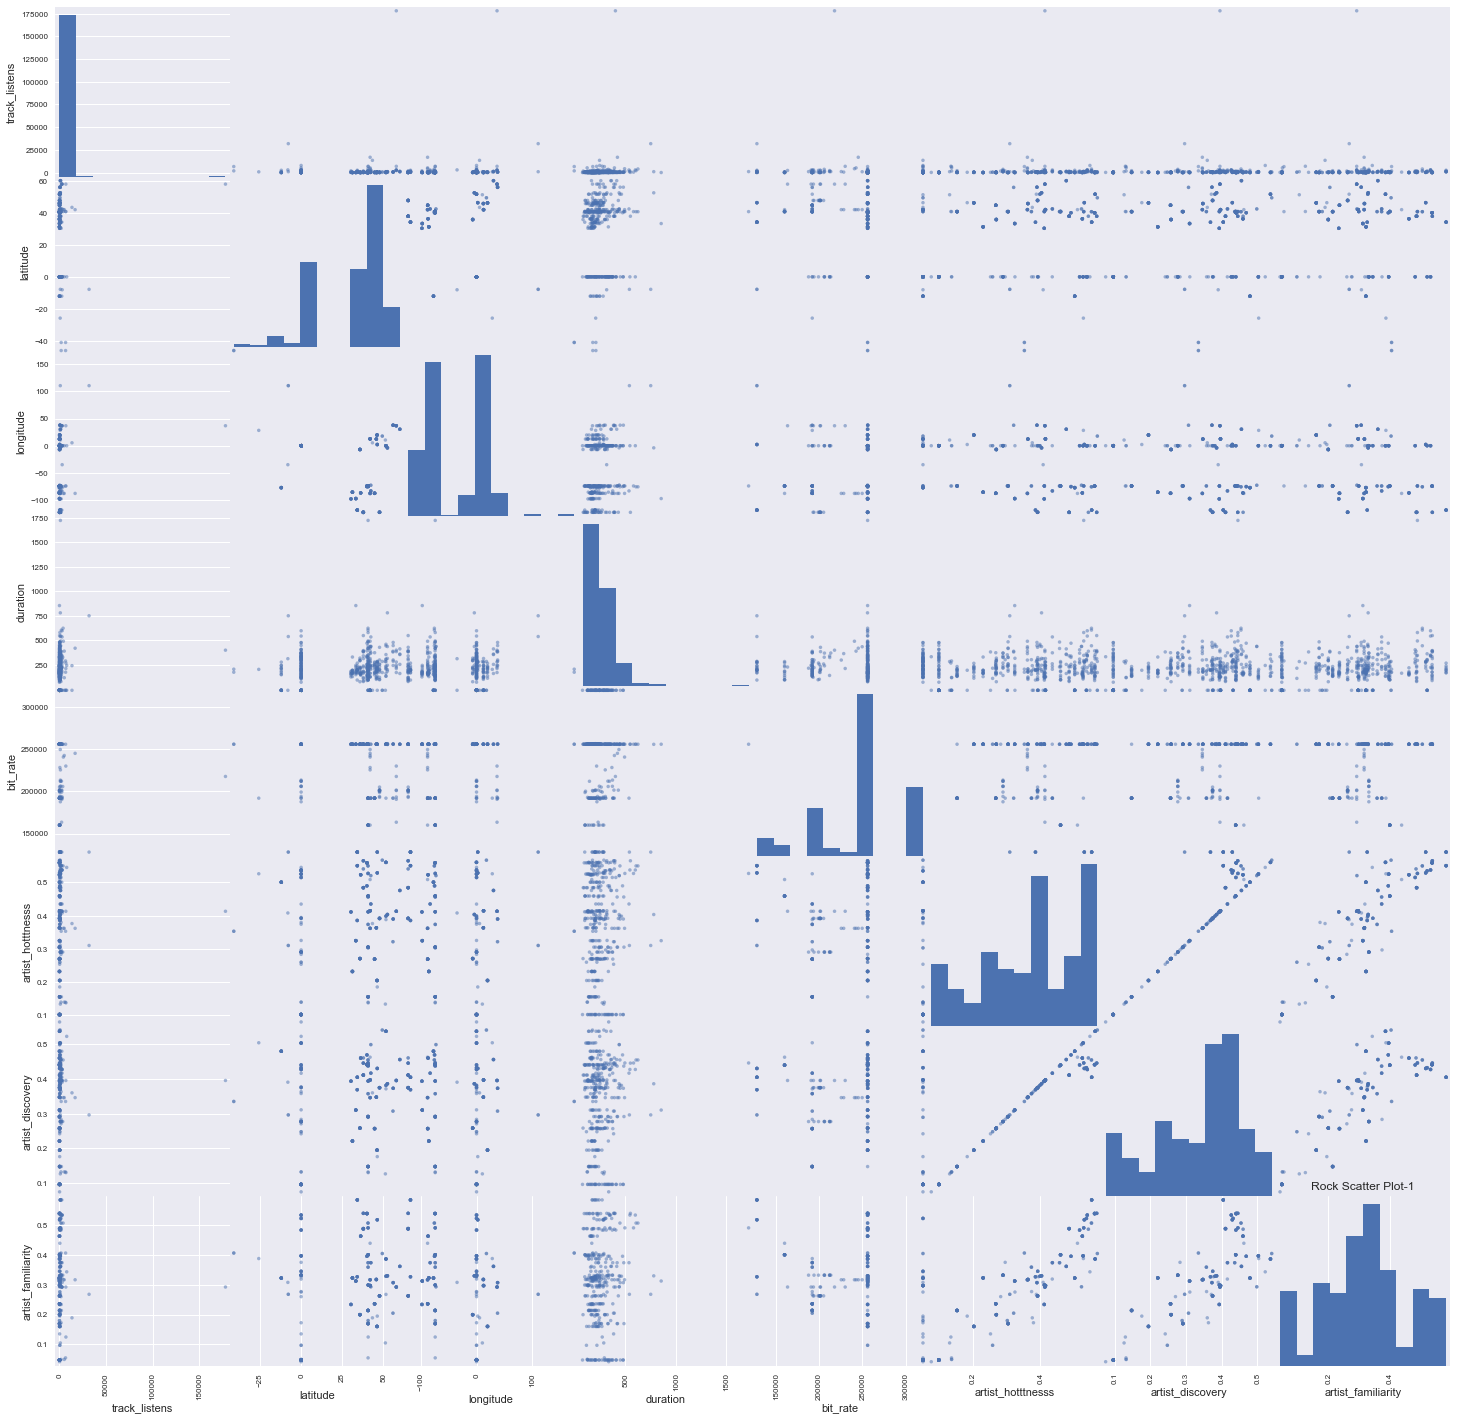

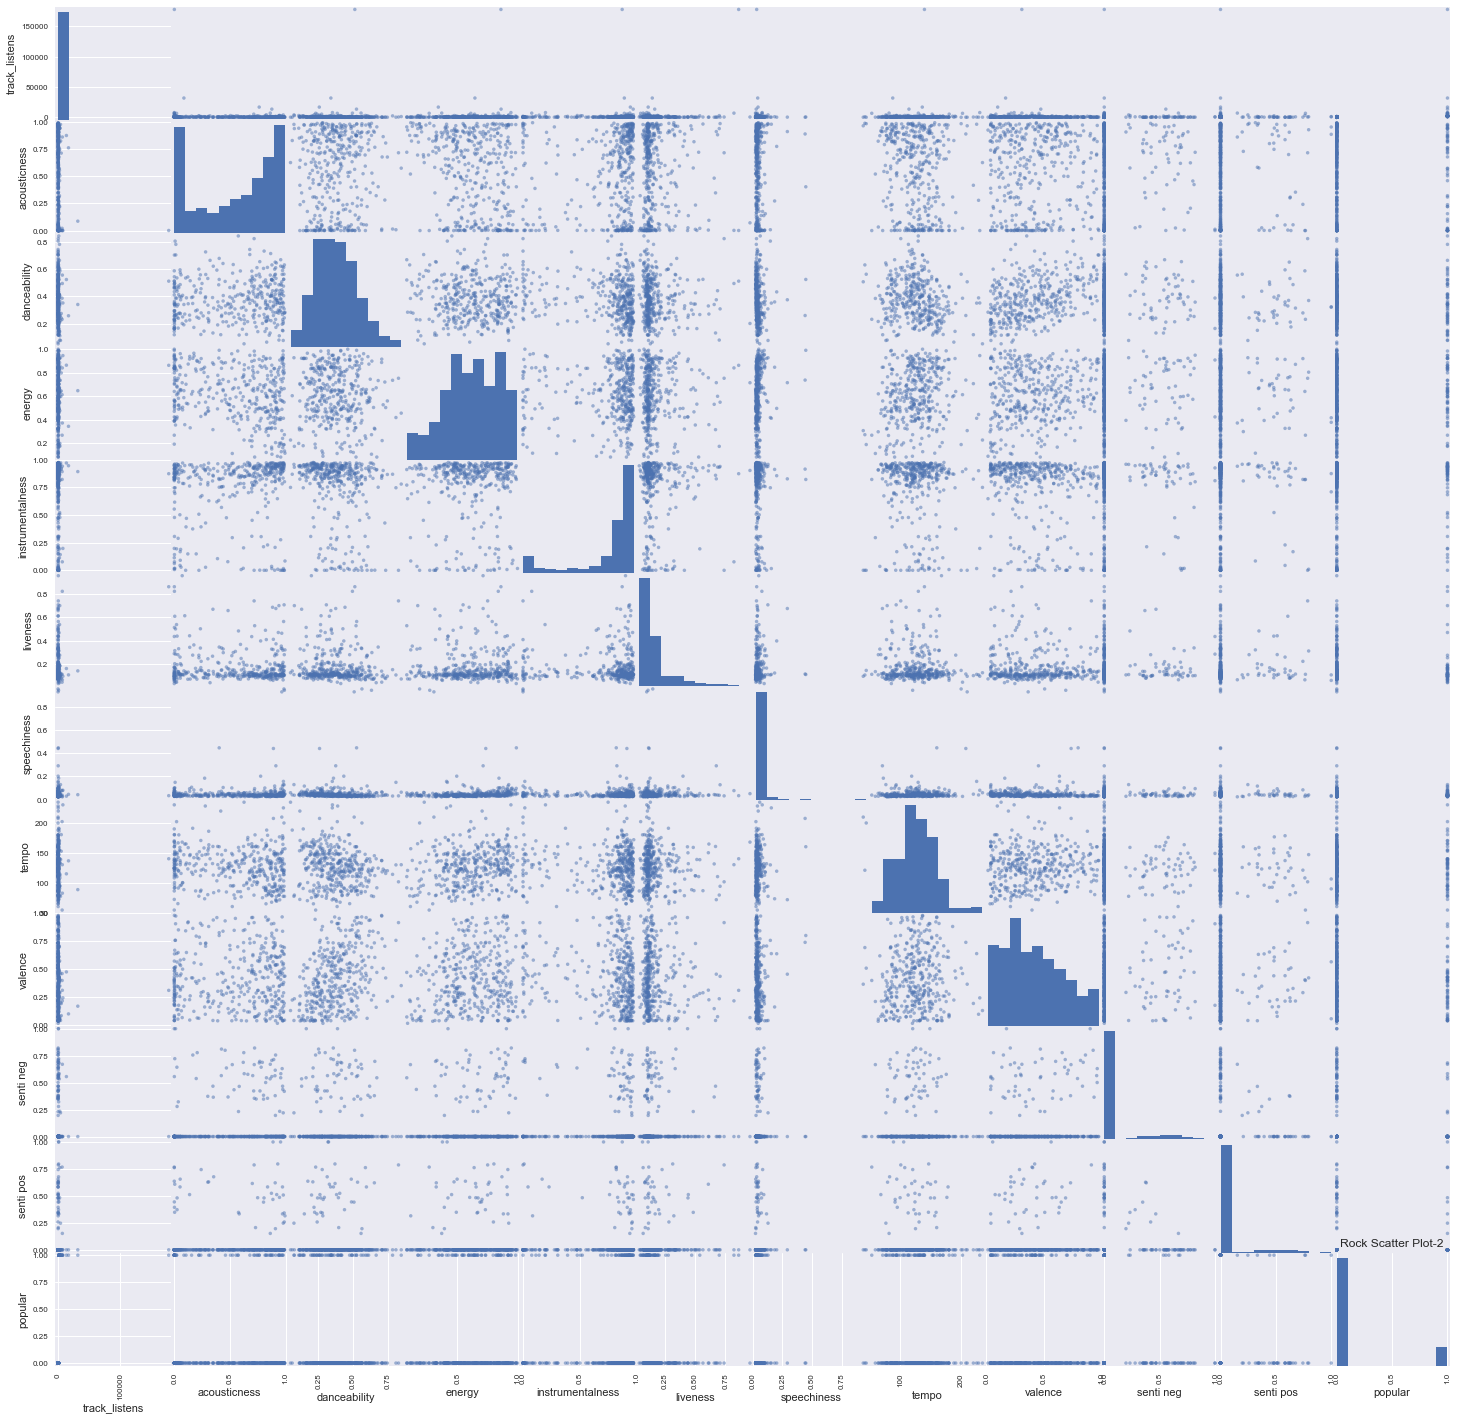

In [12]:
# Make scatter plots of numerical variables versus outcome (track listens)

#Rock
rock10=Rock_10.drop(['track_ID'], axis=1)
rockm=rock10.apply(pd.to_numeric, errors='coerce')
rock102=rockm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
rock101=rockm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

# Scatter matrix for echonest data
scatter_matrix(rock101,figsize=(25,25))
plt.title('Rock Scatter Plot-1')
plt.show()

# Scatter matrix for track data
scatter_matrix(rock102,figsize=(25,25))
plt.title('Rock Scatter Plot-2')
plt.show()


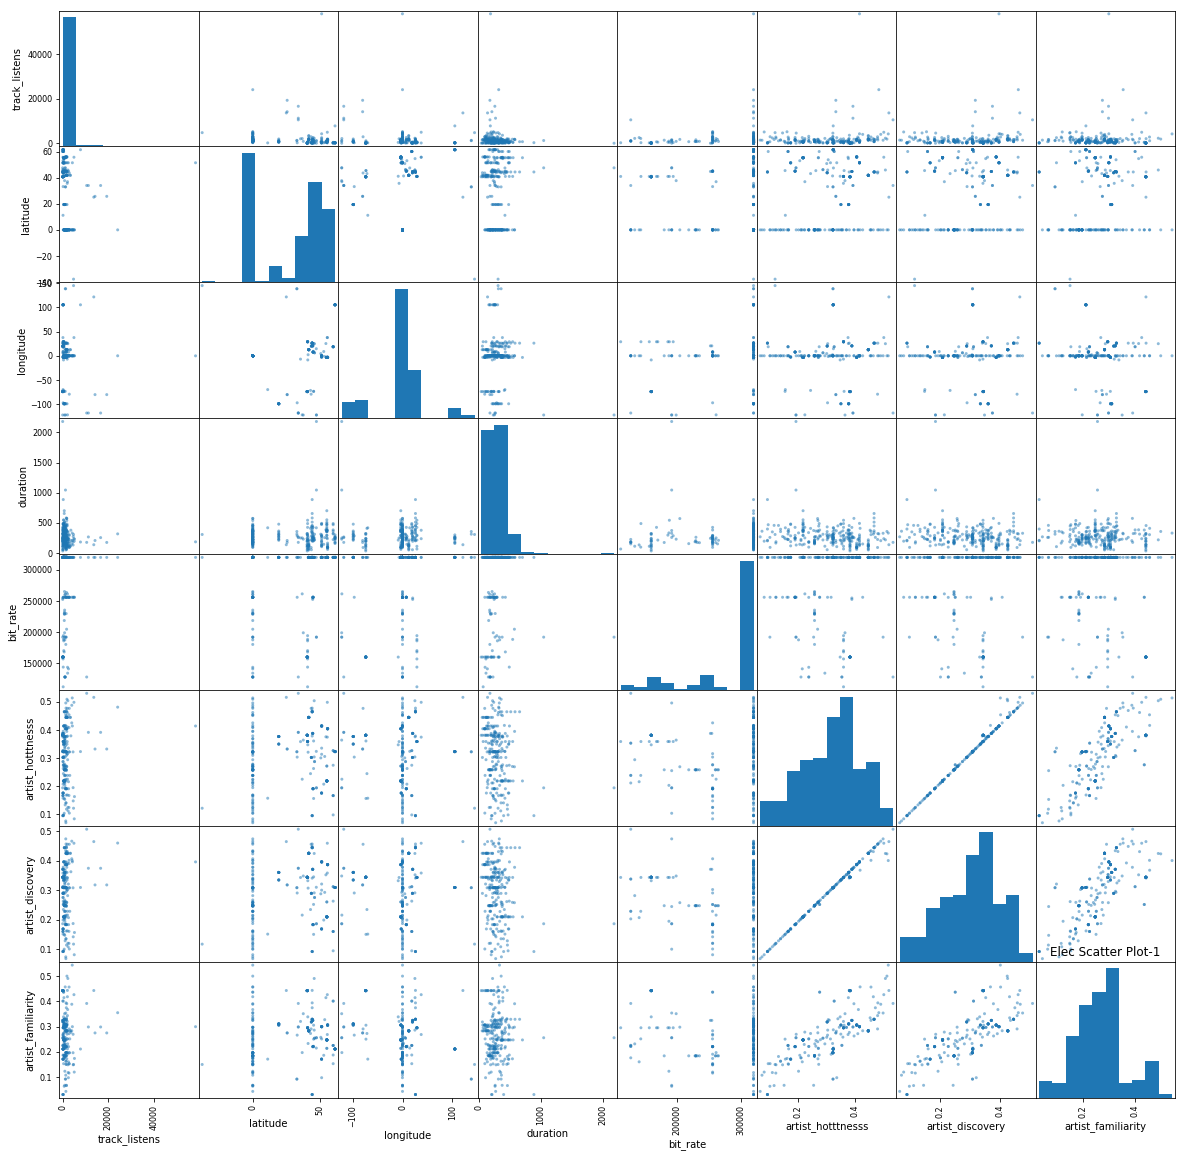

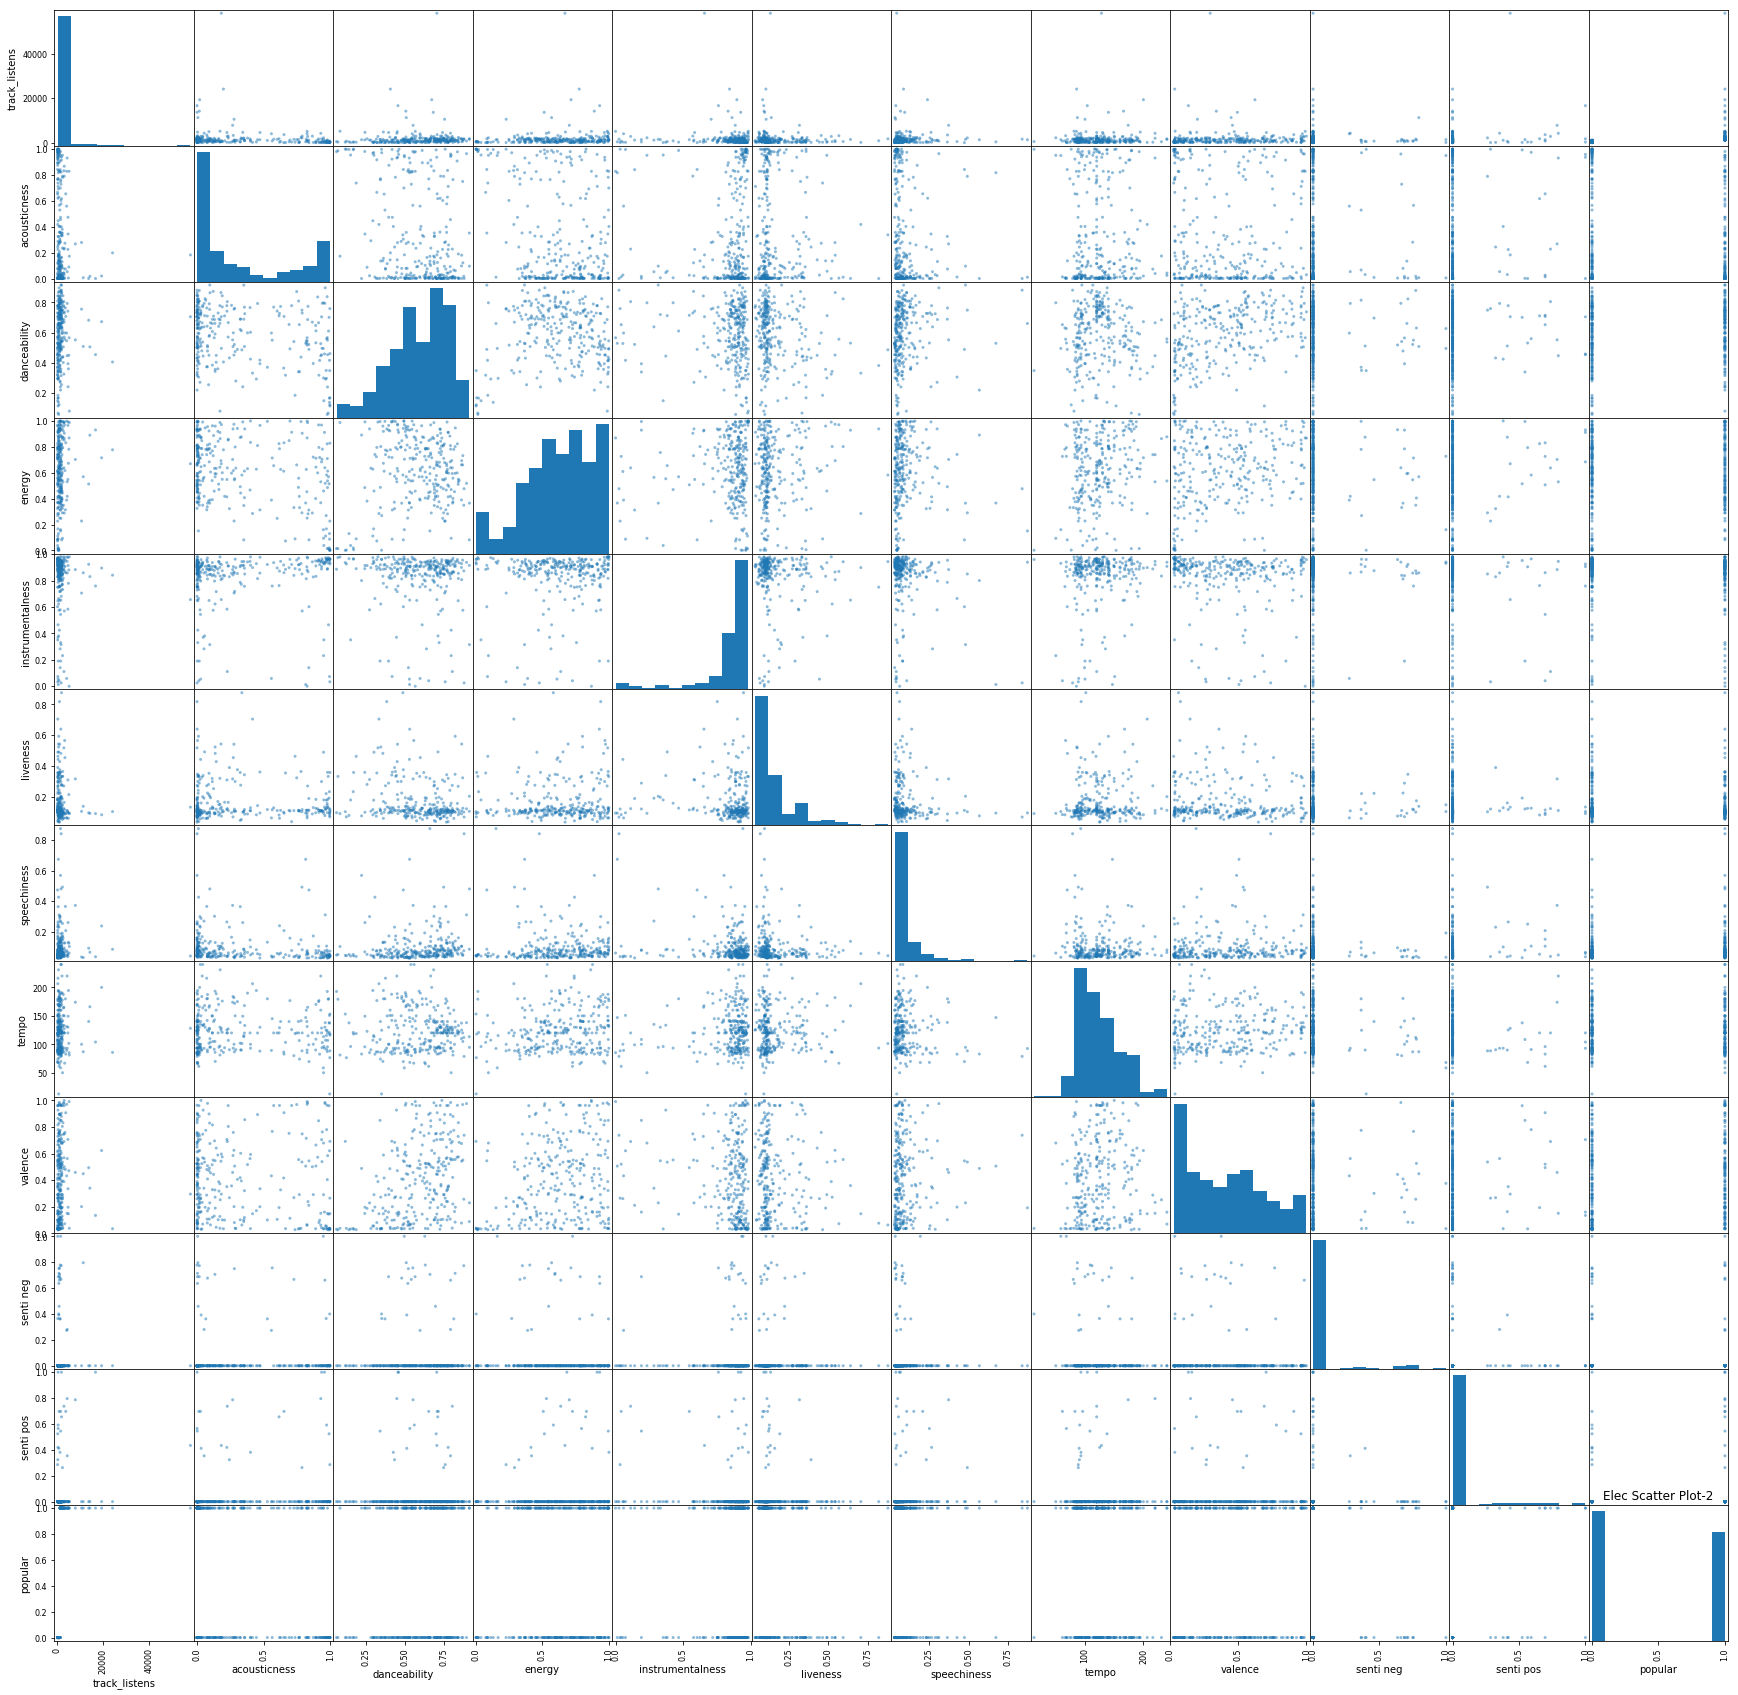

In [15]:
#Electronic
elec10=Elec_10.drop(['track_ID'], axis=1)
elecm=elec10.apply(pd.to_numeric, errors='coerce')
elec102=elecm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
elec101=elecm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

scatter_matrix(elec101,figsize=(20,20))
plt.title('Elec Scatter Plot-1')
plt.show()

scatter_matrix(elec102,figsize=(30,30))
plt.title('Elec Scatter Plot-2')
plt.show()

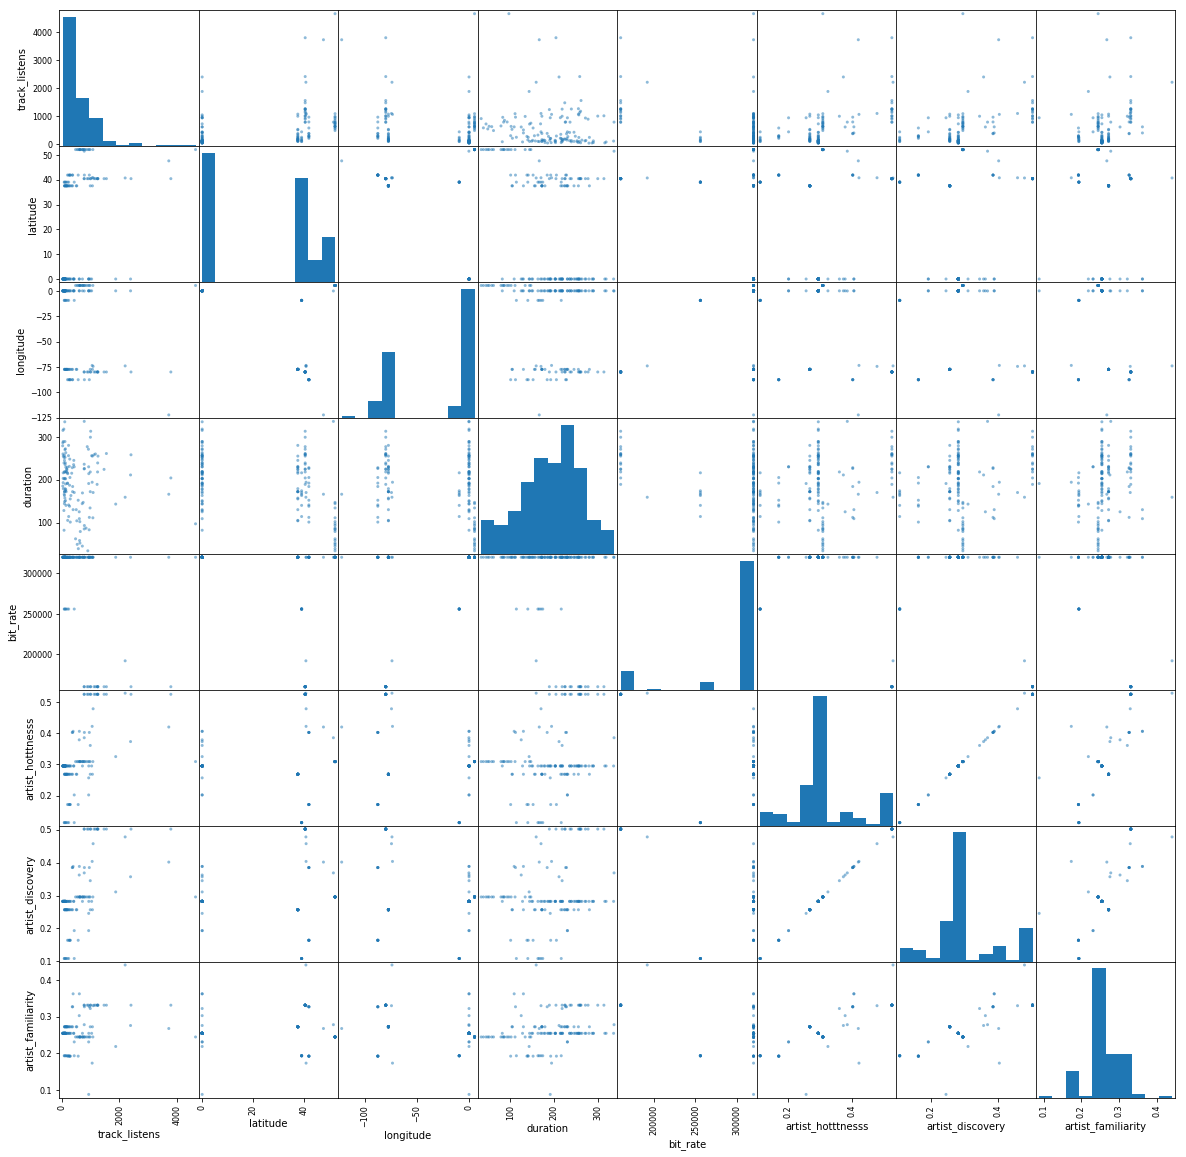

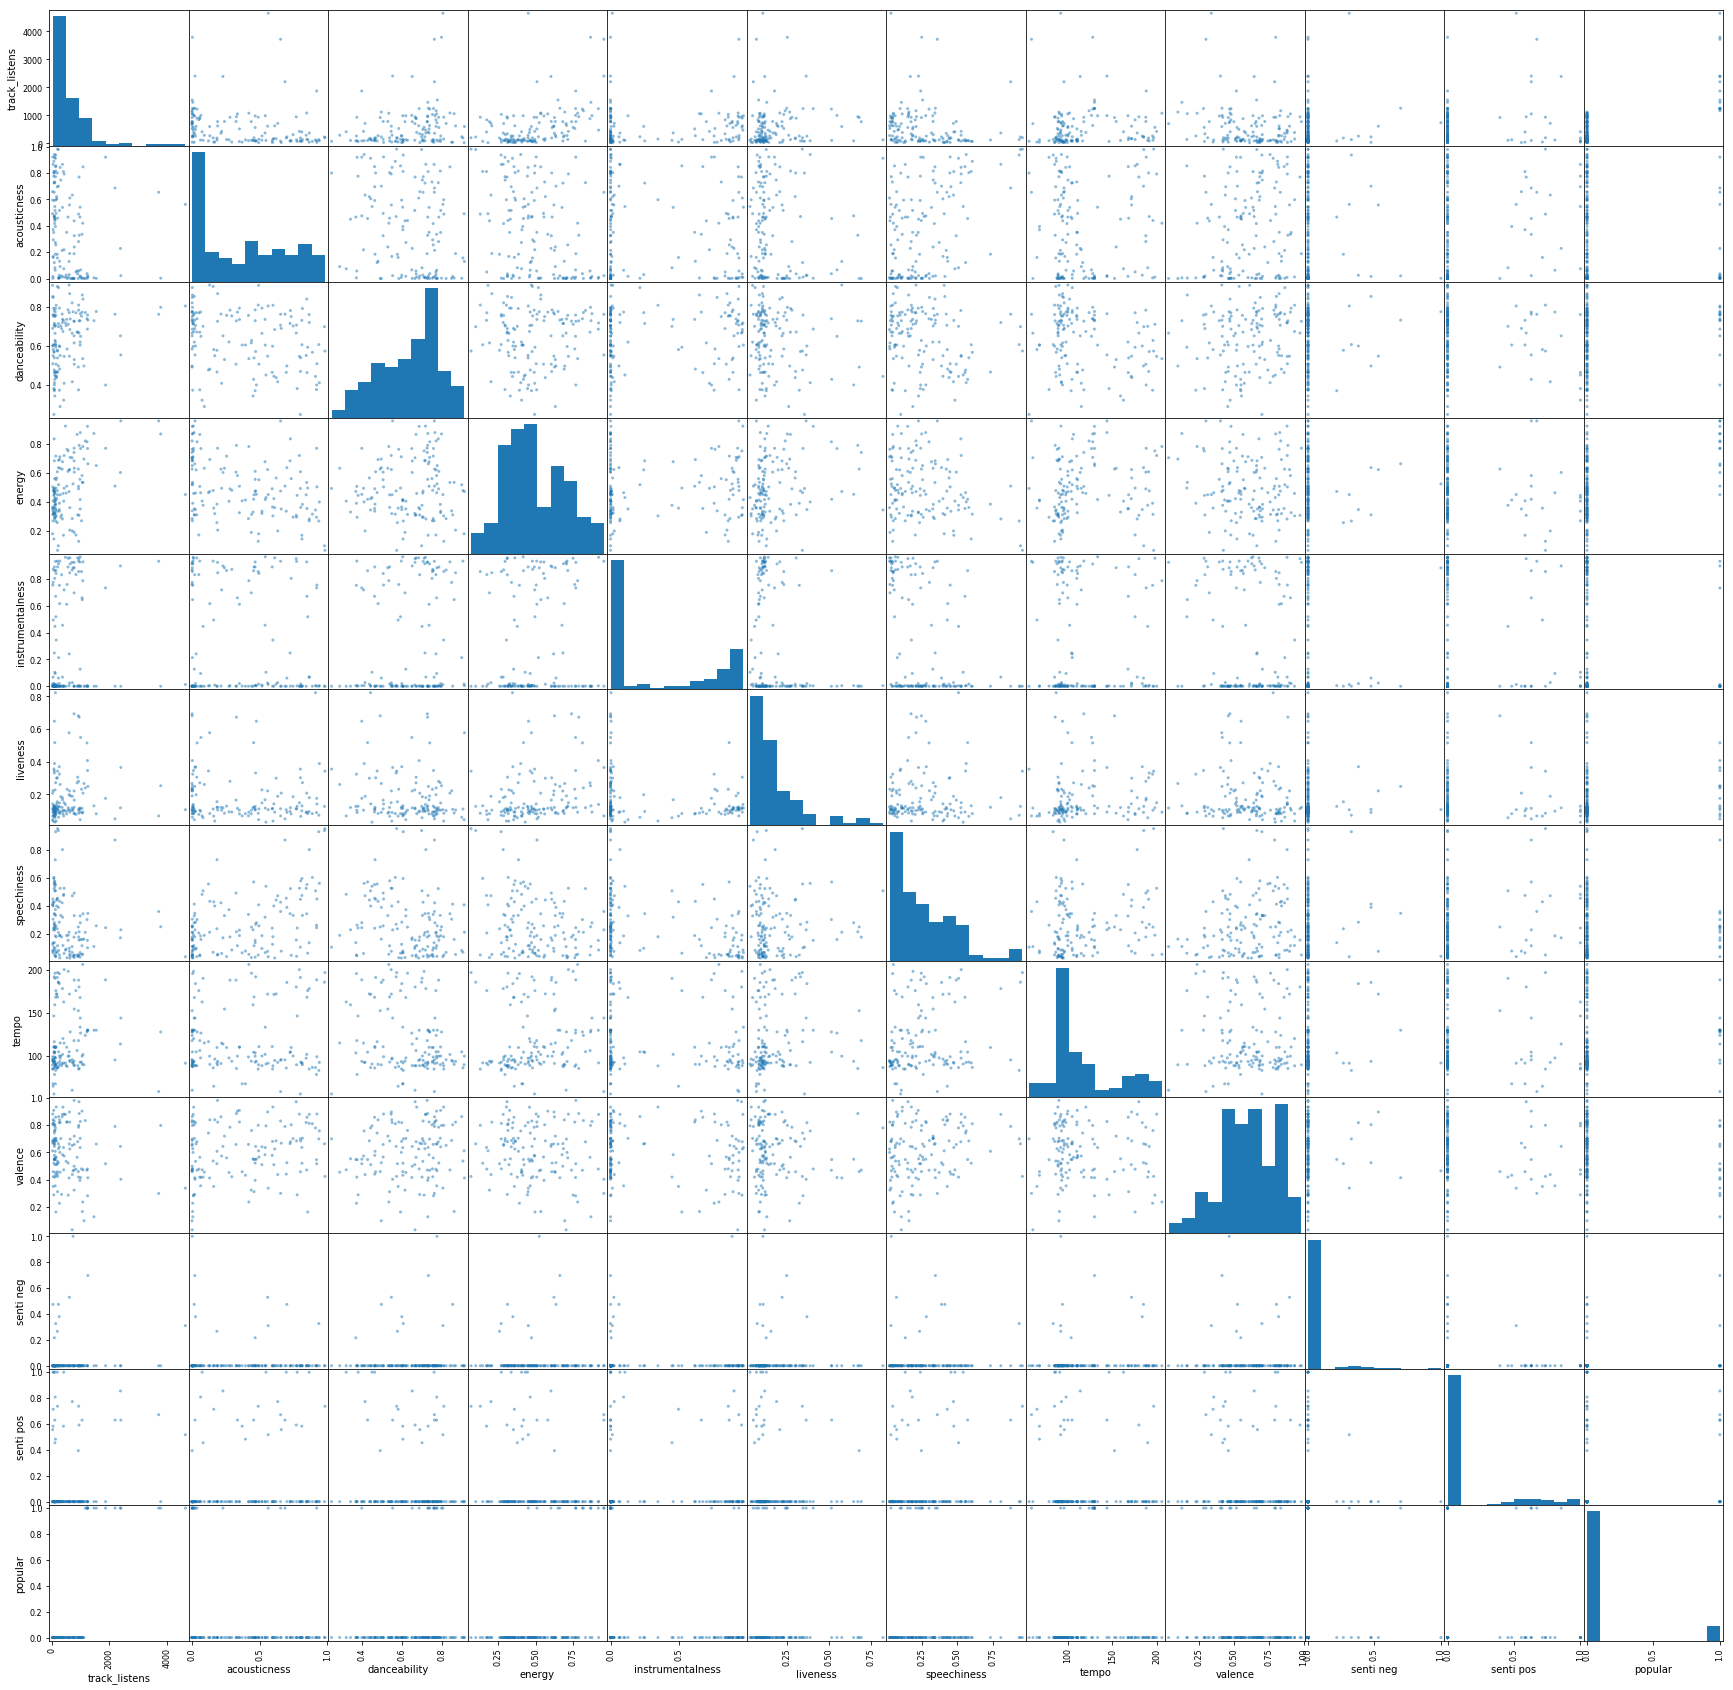

In [16]:
#hip hop
hp=Hiphop_10.drop(['track_ID'], axis=1)
hhm=hp.apply(pd.to_numeric, errors='coerce')
hh102=hhm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
hh101=hhm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

scatter_matrix(hh101,figsize=(20,20))
plt.show()

scatter_matrix(hh102,figsize=(30,30))
plt.show()

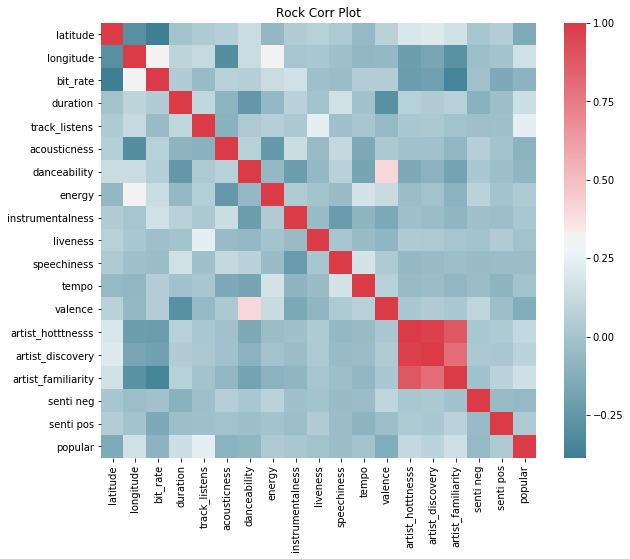

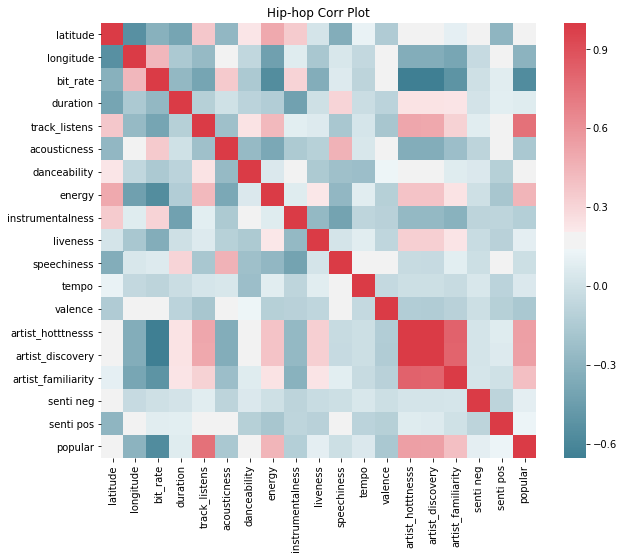

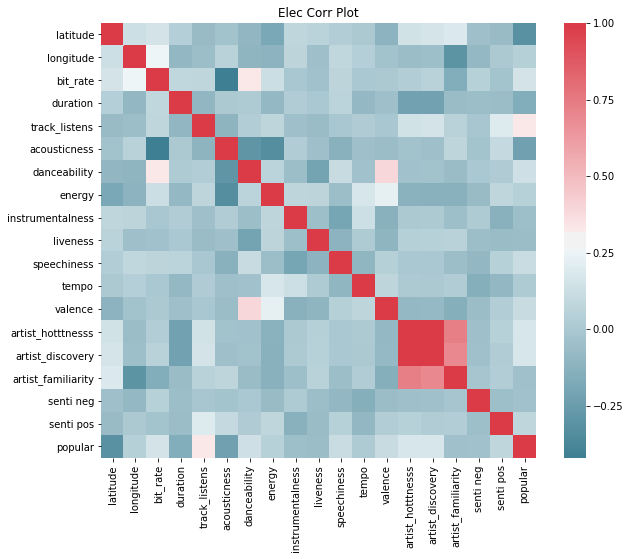

In [17]:
# Correlation plots between varaibles

import seaborn as sns

# Rock
f, ax = plt.subplots(figsize=(10, 8))
corr = rockm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Rock Corr Plot')
plt.show()

# Hip hop
f, ax = plt.subplots(figsize=(10, 8))
corr = hhm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Hip-hop Corr Plot')
plt.show()

# Electronic
f, ax = plt.subplots(figsize=(10, 8))
corr = elecm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Elec Corr Plot')
plt.show()



We see strong correlation between artist hotttness, artist discovery and artist familiarity, which is consistent with intuition - we will select one of these moving forward.

# Model selection

## Baseline Model with logistic regression

In [87]:
# Function for plotting ROC
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve : 0.767172


/Users/kathyli/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


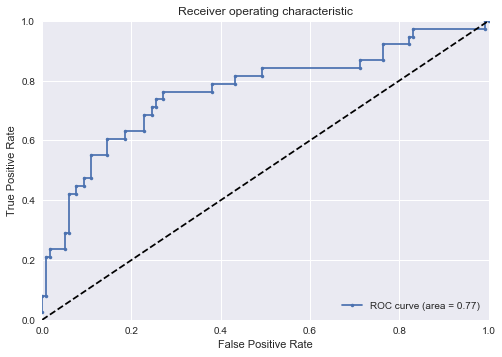

In [88]:
# Train logistic regression on popularity  - include genre as a categorical variable
from sklearn.linear_model import LogisticRegression
y = t10['popular']
X=t10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

regr = LogisticRegression(penalty='l1')
regr.fit(X_train, y_train)

#compute AUC ROC
import sklearn.metrics
from sklearn.metrics import roc_curve, auc

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

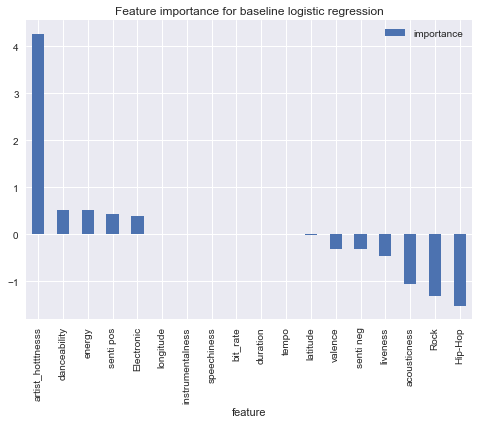

                   importance
feature                      
artist_hotttnesss    4.259583
danceability         0.520708
energy               0.506563
senti pos            0.418389
Electronic           0.376332


In [89]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':t10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for baseline logistic regression')
plt.show()
print(importances[:5])

Since the genre variables are important, different genres can be analyzed separately to see what makes these genres distinct.

# Rock Music

In [90]:
# scale the data and split to train - test sets
y = Rock_10[['popular']].values.ravel()
X=Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

## Logistic Regression - rock 

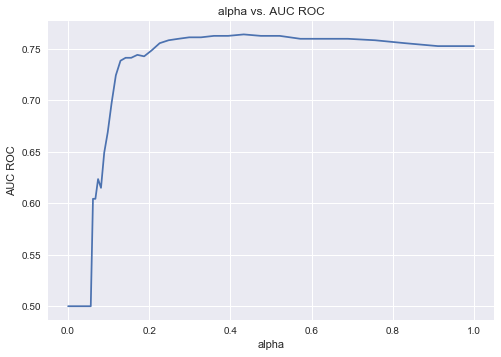

Optimal C value for logistic regression: 0.432876128108


In [91]:
# Regularize over L1 penalty 
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best_L1))

Area under the ROC curve : 0.764205


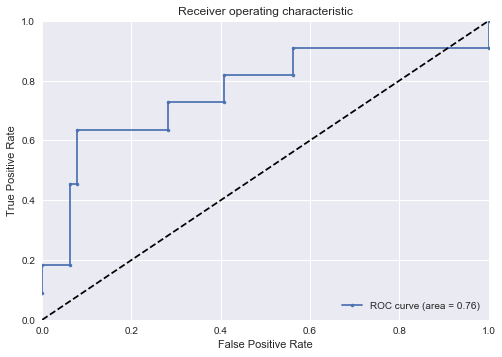

In [92]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

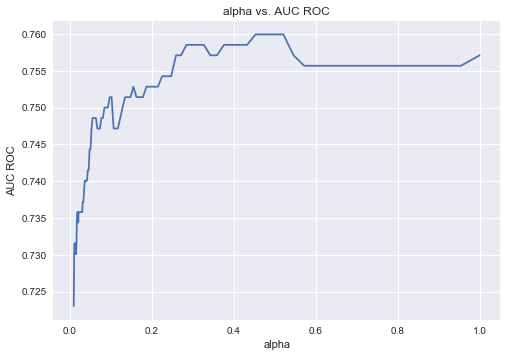

Optimal C value for logistic regression: 0.453487850813


In [93]:
# Regularization with L2 penalty instead
C_vals = np.logspace(-2,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.759943


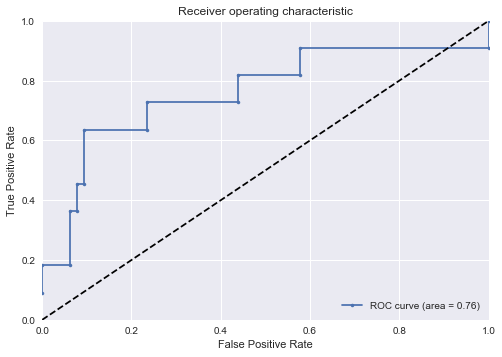

In [94]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[ 0.5078125   0.48917749  0.61760462  0.70707071  0.63492063]


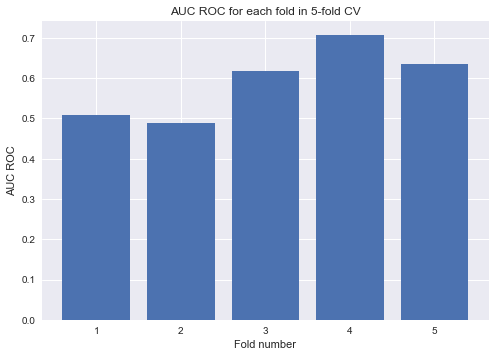

0.591317189755


In [95]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

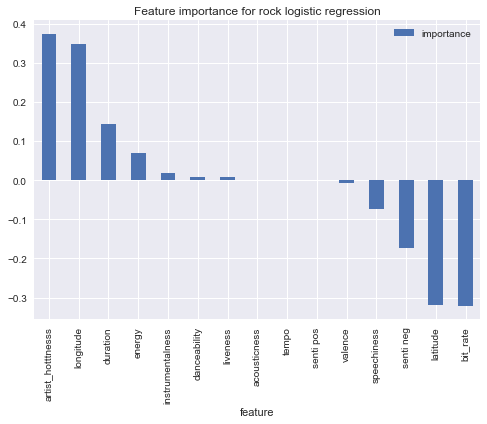

                   importance
feature                      
artist_hotttnesss    0.373913
longitude            0.348567
duration             0.142888
energy               0.069105
instrumentalness     0.019366


In [96]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock logistic regression')
plt.show()
print(importances[:5])

# Decision tree

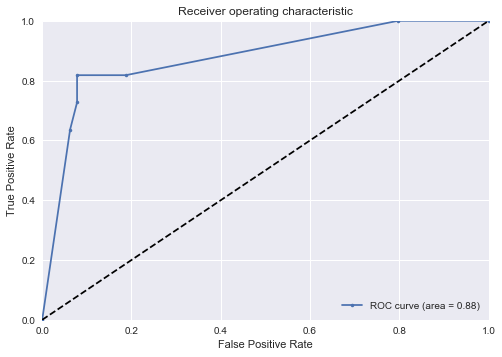

'pydotplus.find_graphviz()\nregr = DecisionTreeClassifier(max_depth=7)\nregr = regr.fit(X, y)\ndot_file = open(\'dt.dot\',\'w\')\nexport_graphviz(regr, out_file=\'dt.dot\')\n\nos.system("dot -Tpng dt.dot -o dtree.png")\nim = Image(\'dtree.png\')\nim.format = "png"\ndisplay(im)'

In [99]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

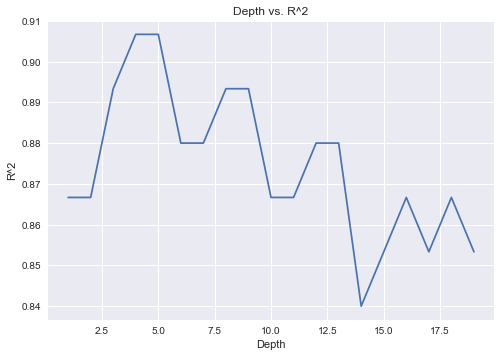

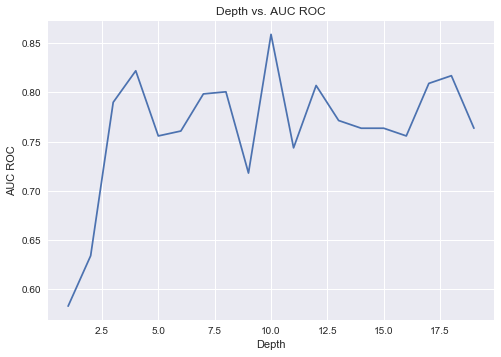

Optimal depth: 10


In [100]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

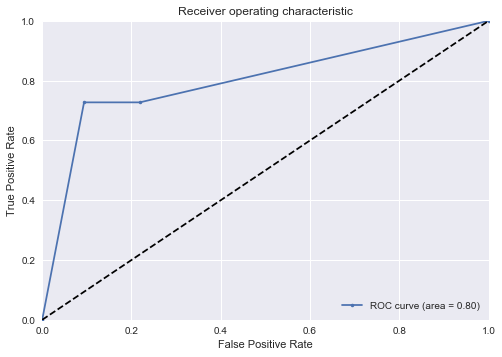

In [101]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

[ 0.55208333  0.45165945  0.46103896  0.64213564  0.53823954]


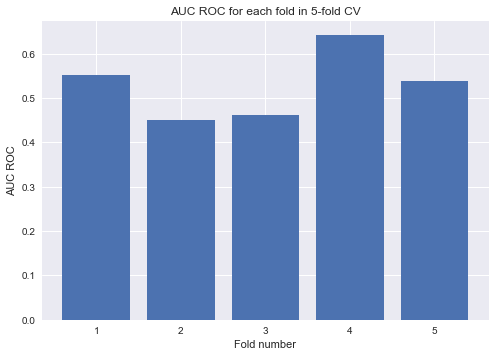

0.529031385281


In [102]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

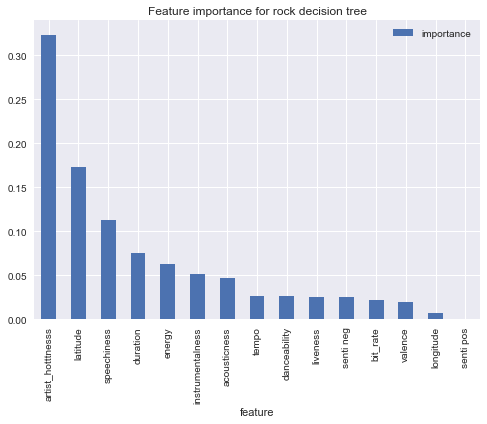

                   importance
feature                      
artist_hotttnesss    0.323643
latitude             0.173625
speechiness          0.112421
duration             0.075915
energy               0.063334


In [103]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock decision tree')
plt.show()
print(importances[:5])

# Random forest

89.3333333333


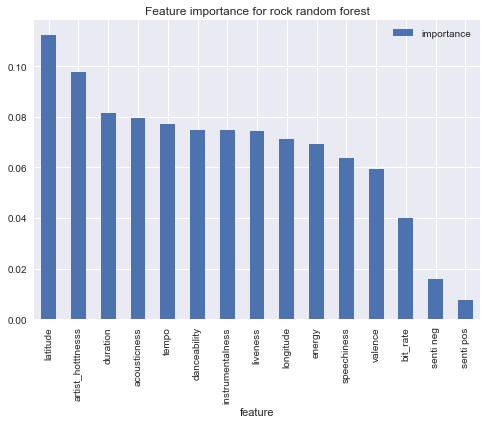

                   importance
feature                      
latitude             0.112492
artist_hotttnesss    0.097589
duration             0.081488
acousticness         0.079612
tempo                0.077333


In [26]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock random forest')
plt.show()
print(importances[:5])

In [27]:
# Check for different tree depths and number of features 
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 2, 'max_features': 8}

Area under the ROC curve : 0.855114


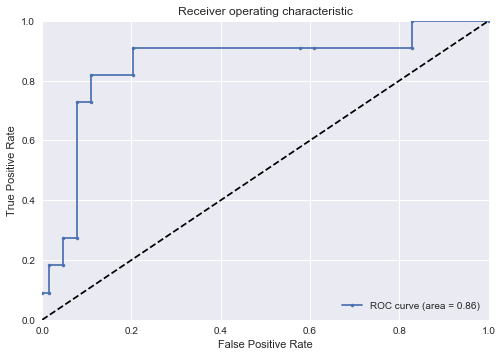

In [28]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [29]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.62695312  0.46825397  0.58297258  0.76984127  0.55122655]
Mean: 0.599849499459
Standard Deviation: 0.0995974033328


[ 0.60221354  0.45598846  0.57864358  0.75613276  0.53318903]


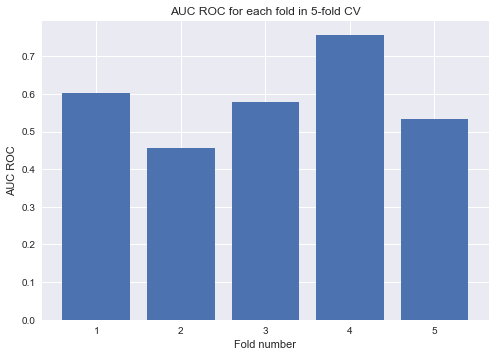

In [30]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

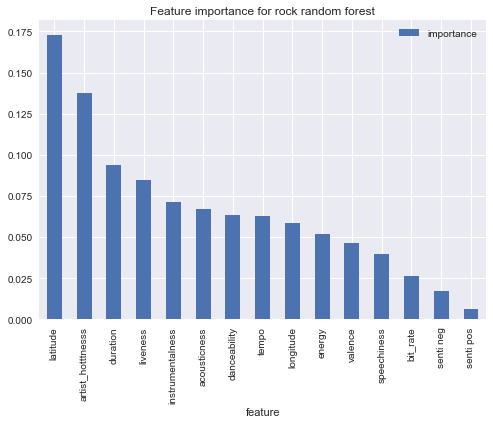

                   importance
feature                      
latitude             0.173079
artist_hotttnesss    0.137845
duration             0.094079
liveness             0.084429
instrumentalness     0.071427


In [113]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [31]:
#Reset Data
y = Rock_10[['popular']].values.ravel()
X=Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [32]:
#Run grid search for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 6}

In [33]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

86.6666666667


In [34]:
#Cross Validation

knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.63997396  0.47907648  0.57431457  0.62337662  0.67604618]
Mean: 0.598557562229
Standard Deviation: 0.0681164306583


[ 0.63997396  0.47907648  0.57431457  0.62337662  0.67604618]


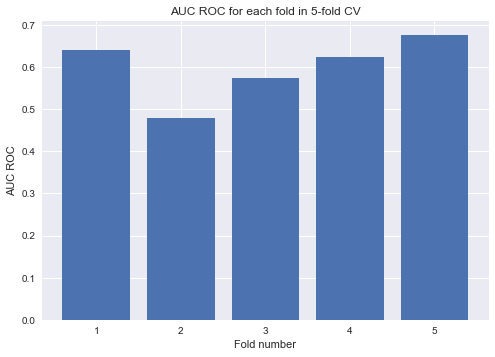

In [35]:
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

In [85]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':knn.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock KNN')
plt.show()
print(importances[:5])

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

# Hiphop music

In [36]:
# scale the data and split to train - test sets
y = Hiphop_10[['popular']].values.ravel()
X=Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

# Logistic regression

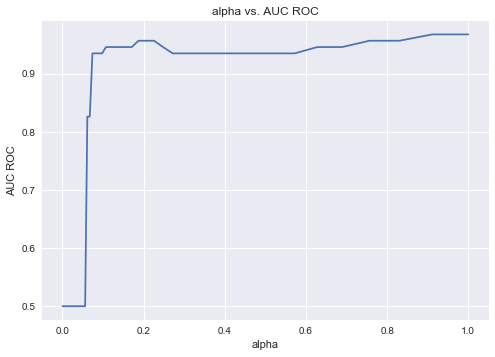

Optimal C value for logistic regression: 0.453487850813


In [37]:
# L1 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.967391


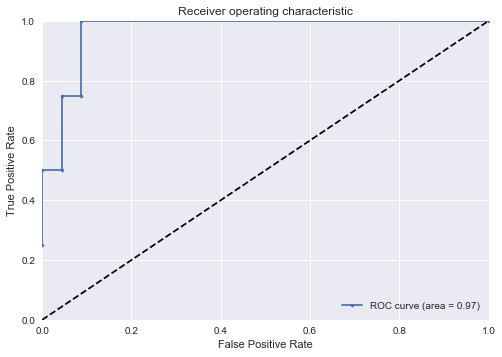

In [38]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

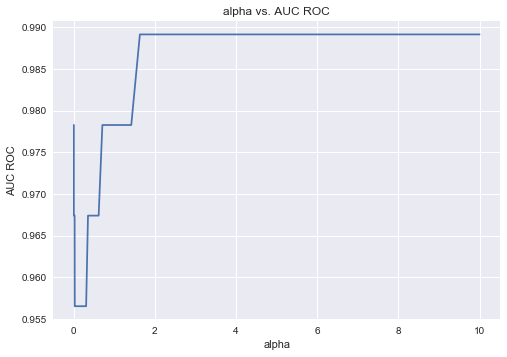

Optimal C value for logistic regression: 1.62975083462


In [39]:
# L2 penalty
C_vals = np.logspace(-5,1,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.989130


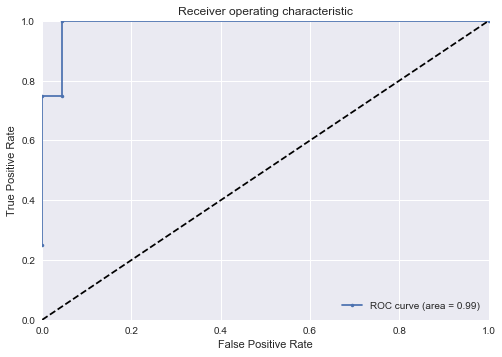

In [40]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[ 0.79166667  0.90277778  0.98611111  0.95833333  0.91304348]
0.91038647343


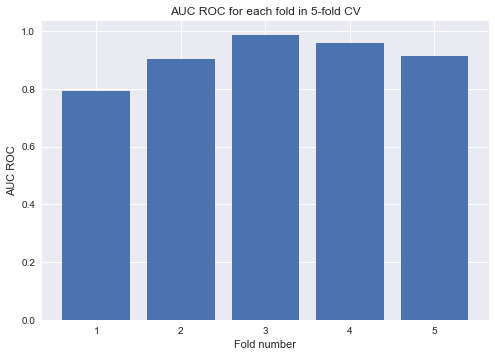

In [42]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

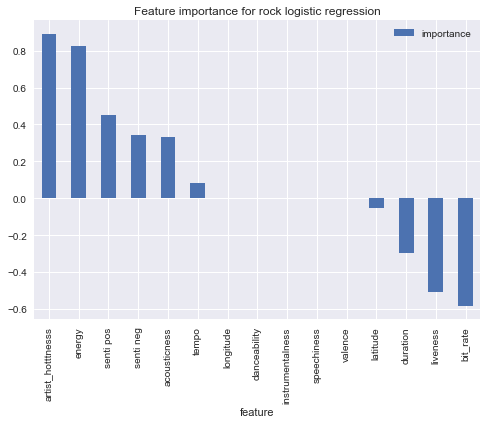

                   importance
feature                      
artist_hotttnesss    0.891329
energy               0.824288
senti pos            0.452778
senti neg            0.341365
acousticness         0.332126


In [92]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop logistic regression')
plt.show()
print(importances[:5])

# Decision tree

In [ ]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

In [ ]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

In [ ]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

In [ ]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock decision tree')
plt.show()
print(importances[:5])

In [ ]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop decision tree')
plt.show()
print(importances[:5])

# Random Forest

85.1851851852


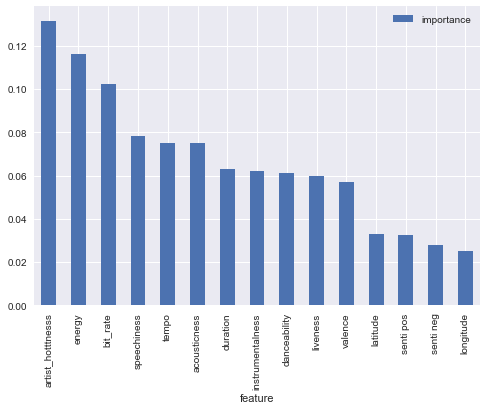

                   importance
feature                      
artist_hotttnesss    0.131648
energy               0.116200
bit_rate             0.102147
speechiness          0.078100
tempo                0.075111


In [43]:
# random forest for hip hop - baseline
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()
print(importances[:5])

In [44]:
#check for different tree depths - regularize
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 2, 'max_features': 7}

Area under the ROC curve : 0.967391


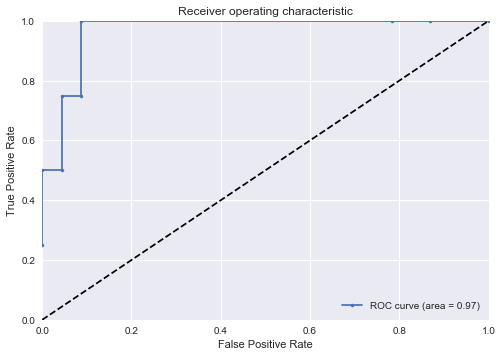

In [45]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [46]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.88888889  0.88888889  0.88888889  0.92592593  0.68      ]
Mean: 0.854518518519
Standard Deviation: 0.0884304226121


[ 0.52777778  0.95833333  1.          1.          0.89130435]


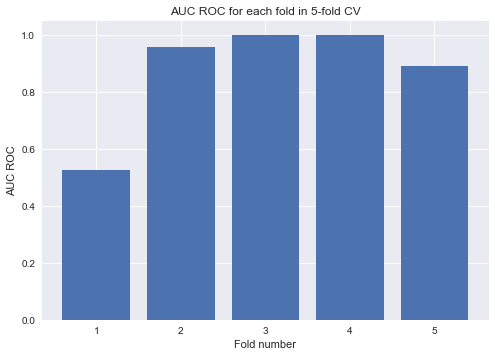

In [47]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

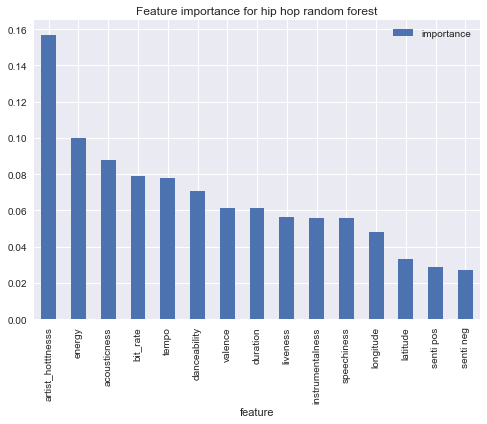

                   importance
feature                      
artist_hotttnesss    0.157003
energy               0.100018
acousticness         0.088024
bit_rate             0.078971
tempo                0.077677


In [120]:
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [48]:
# scale the data and split to train - test sets
y = Hiphop_10[['popular']].values.ravel()
X=Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [49]:
#Run grid search for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(2,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 5}

In [50]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

81.4814814815


In [51]:
#Cross Validation

knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.65277778  0.65277778  0.98611111  1.          0.84782609]
Mean: 0.827898550725
Standard Deviation: 0.152565920206


[ 0.65277778  0.65277778  0.98611111  1.          0.84782609]


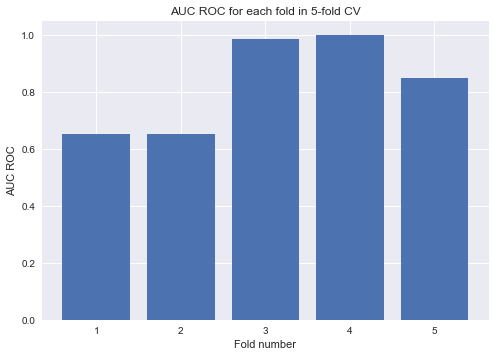

In [52]:
# cross validation
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

# Electronic Music

In [53]:
# scale the data and split to train - test sets
y = Elec_10[['popular']].values.ravel()
X=Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

# Logistic Regression

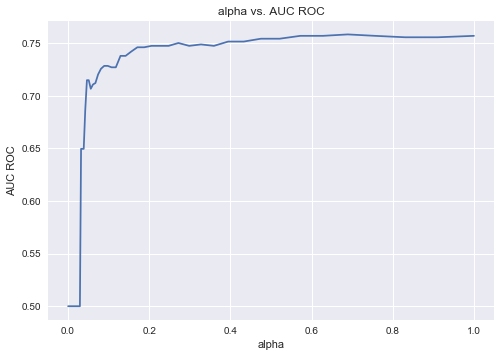

Optimal C value for logistic regression: 1.62975083462


In [54]:
# L1 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.758152


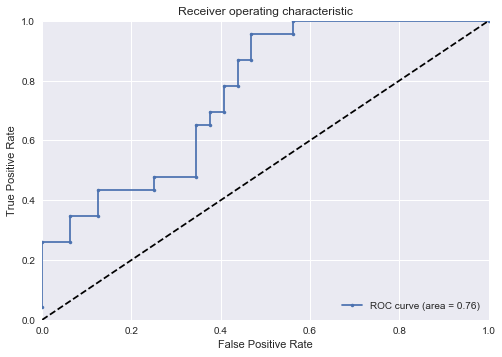

In [55]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

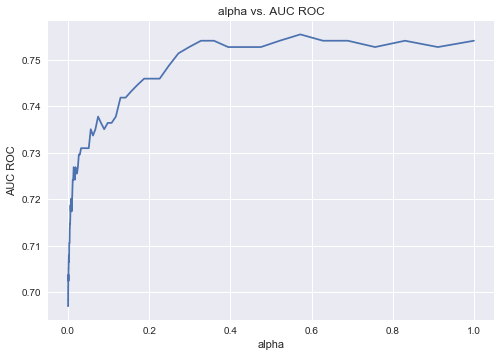

Optimal C value for logistic regression: 0.572236765935


In [56]:
#L2 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.755435


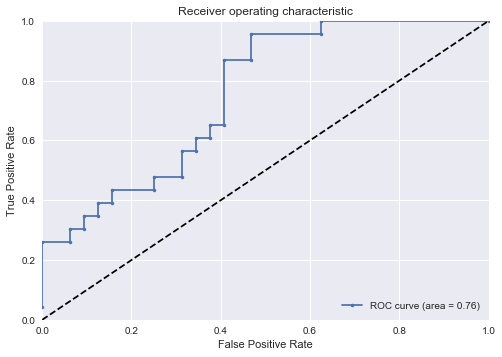

In [57]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[ 0.436       0.74133333  0.89241379  0.55172414  0.80890805]
0.686075862069


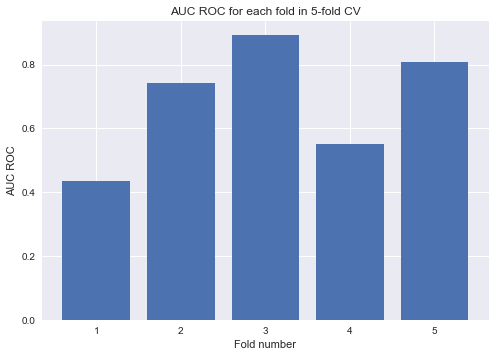

In [59]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

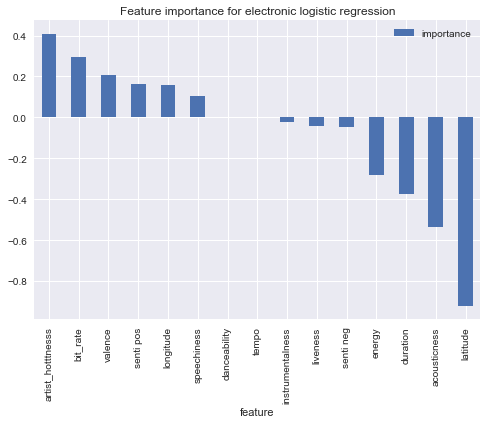

                   importance
feature                      
artist_hotttnesss    0.408037
bit_rate             0.293849
valence              0.205576
senti pos            0.165353
longitude            0.156597


In [134]:
importances = pd.DataFrame({'feature':Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic logistic regression')
plt.show()
print(importances[:5])

In [ ]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

In [ ]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

In [ ]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

In [ ]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

In [ ]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic decision tree')
plt.show()
print(importances[:5])

# Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
print(importances[:5])

80.0
                   importance
feature                      
artist_hotttnesss    0.140344
latitude             0.111701
acousticness         0.087424
longitude            0.086631
liveness             0.076554


In [61]:
#check for different tree depths 
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 4, 'max_features': 8}

Area under the ROC curve : 0.834239


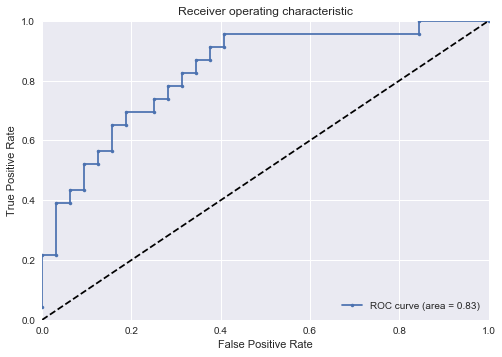

In [62]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [63]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.48666667  0.90266667  0.72413793  0.45103448  0.33333333]
Mean: 0.579567816092
Standard Deviation: 0.205463499055


[ 0.49333333  0.89733333  0.72827586  0.43310345  0.39511494]


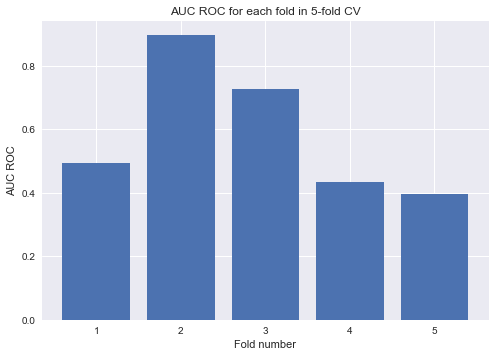

In [64]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

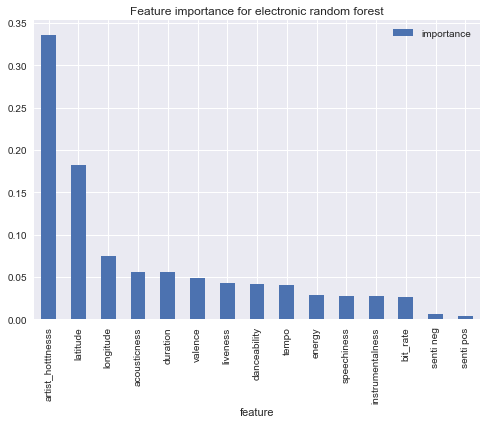

                   importance
feature                      
artist_hotttnesss    0.336328
latitude             0.182589
longitude            0.074655
acousticness         0.056298
duration             0.056232


In [140]:
importances = pd.DataFrame({'feature':Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [65]:
# scale the data and split to train - test sets
y = Elec_10[['popular']].values.ravel()
X=Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [66]:
#Run grid serach for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(2,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 7}

In [67]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

74.5454545455


In [73]:
#Cross Validation
knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.47333333  0.78266667  0.78965517  0.48413793  0.60704023]
Mean: 0.627366666667
Standard Deviation: 0.137919941719


[ 0.47333333  0.78266667  0.78965517  0.48413793  0.60704023]


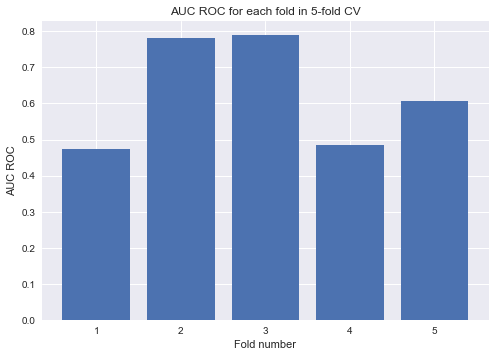

In [74]:
# cross validation
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

## Extra stuff

In [ ]:
# Write function that takes in optimal_model, new song audio and necessary info (like genre, track title, etc.) and uses librosa to extract features
# and output a prediction of number of track listens 

# for testing a new song, im not sure if our model gonna use "features", so i'll also look for data in "echonest "

# librosa code only extract same data on features

# Load the example clip
# Load 30 seconds of a wav file, starting 15 seconds in
y, sr = librosa.load('blahblah.mp3', offset=15.0, duration=30.0)

# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)

# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)

# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

# Finally, stack all beat-synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [ ]:
##Statistic for each feature
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()


def feature_stats(name, values):
    features[name, 'mean'] = np.mean(values, axis=1)
    features[name, 'std'] = np.std(values, axis=1)
    features[name, 'skew'] = stats.skew(values, axis=1)
    features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
    features[name, 'median'] = np.median(values, axis=1)
    features[name, 'min'] = np.min(values, axis=1)
    features[name, 'max'] = np.max(values, axis=1)


features = pd.Series(index=columns(), dtype=np.float32)


In [ ]:
##
y, sr = librosa.load('xxx.mp3', offset=15.0, duration=30.0)

stft=np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
feature_stats('chroma_stft', f)

f = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512)
feature_stats('zcr', f)

cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
assert cqt.shape[0] == 7 * 12
assert np.ceil(len(y)/512) <= cqt.shape[1] <= np.ceil(len(y)/512)+1


f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cqt', f)

f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cens', f)

f = librosa.feature.tonnetz(chroma=f)
feature_stats('tonnetz', f)

print(features)